In [1]:
# imports
import os
import sys

# Adiciona o diretório raiz do projeto ao PYTHONPATH para importar o pacote local
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
from nasabinning.binning_engine import NASABinner
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

In [2]:
def generate_credit_risk_dataset(
    n: int = 1_000_000,
    seed: int = 42,
    anos_meses_possiveis: list[int] = [202301, 202302, 202303, 202304, 202305]
) -> pd.DataFrame:
    """
    Gera um DataFrame sintético para contexto de risco de crédito.
    
    Parâmetros
    ----------
    n : int
        Número de linhas (clientes) desejadas. Default = 1_000_000.
    seed : int
        Semente para aleatoriedade (reprodutibilidade). Default = 42.
    anos_meses_possiveis : list[int]
        Lista de códigos de referência de mês (AnoMesReferencia) utilizados
        para simular diferentes períodos. Ex.: [202301, 202302, ...].
    
    Retorna
    -------
    pd.DataFrame
        DataFrame com as seguintes colunas:
        - idade (float): idade simulada (média 40, desvio 10).
        - renda (float): renda mensal (média 3000, desvio 800).
        - score (float): score de crédito (média 600, desvio 100).
        - AnoMesReferencia (int): período em formato YYYYMM.
        - num_loans (int): número de empréstimos em aberto (distribuição Poisson).
        - debt_to_income (float): relação dívida / renda (entre 0 e 1).
        - num_credit_inquiries (int): número de consultas ao crédito (Poisson).
        - marital_status (categoria): estado civil.
        - education_level (categoria): nível de escolaridade.
        - employment_type (categoria): tipo de vínculo empregatício.
        - residential_status (categoria): situação de moradia.
        - default_90d (int): variável-alvo binária simulada (0 = sem default, 1 = default em até 90 dias).
    """
    np.random.seed(seed)
    
    # 1) Variáveis numéricas básicas
    idade = np.random.normal(loc=40, scale=10, size=n)
    renda = np.random.normal(loc=3000, scale=800, size=n)
    score = np.random.normal(loc=600, scale=100, size=n)
    
    # Garantir que renda e score não fiquem com valores negativos (se ocorrerem)
    renda = np.clip(renda, a_min=200, a_max=None)  # renda mínima de 200
    score = np.clip(score, a_min=300, a_max=850)   # score entre 300 e 850 (faixa típica)
    idade = np.clip(idade, a_min=18, a_max=90)      # faixa etária entre 18 e 90 anos
    
    # 2) Período de referência (AnoMesReferencia)
    AnoMesReferencia = np.random.choice(anos_meses_possiveis, size=n)
    
    # 3) Variáveis adicionais numéricas
    # Número de empréstimos em aberto (Poisson, média = 2)
    num_loans = np.random.poisson(lam=2, size=n)
    
    # Relação dívida / renda (uniforme entre 0 e 1, mas com tendência central)
    debt_to_income = np.random.beta(a=2, b=5, size=n)  # distrib. beta para dar assimetria
    
    # Número de consultas de crédito nos últimos 6 meses (Poisson, média = 1)
    num_credit_inquiries = np.random.poisson(lam=1, size=n)
    
    # 4) Variáveis categóricas
    # Estado civil
    marital_status = np.random.choice(
        ["Single", "Married", "Divorced", "Widowed"],
        size=n,
        p=[0.4, 0.45, 0.1, 0.05]
    )
    
    # Nível de escolaridade
    education_level = np.random.choice(
        ["High School", "Bachelor", "Master", "PhD", "Other"],
        size=n,
        p=[0.35, 0.4, 0.15, 0.05, 0.05]
    )
    
    # Tipo de emprego
    employment_type = np.random.choice(
        ["Salaried", "Self-employed", "Unemployed", "Retired"],
        size=n,
        p=[0.6, 0.15, 0.2, 0.05]
    )
    
    # Status residencial
    residential_status = np.random.choice(
        ["Rent", "Own", "Mortgage"],
        size=n,
        p=[0.5, 0.3, 0.2]
    )
    
    # 5) Montagem do DataFrame
    df = pd.DataFrame({
        "idade": idade,
        "renda": renda,
        "score": score,
        "AnoMesReferencia": AnoMesReferencia,
        "num_loans": num_loans,
        "debt_to_income": debt_to_income,
        "num_credit_inquiries": num_credit_inquiries,
        "marital_status": marital_status,
        "education_level": education_level,
        "employment_type": employment_type,
        "residential_status": residential_status,
    })
    
    # 6) Variável-alvo (default em até 90 dias)
    # Critério simplificado: maior chance de default se score baixo, renda baixa e dívida alta.
    # Calculamos uma pontuação de risco parcial e adicionamos componente aleatório.
    # Primeiro, normalizamos score e renda para 0–1:
    score_norm = (df["score"] - df["score"].min()) / (df["score"].max() - df["score"].min())
    renda_norm = (df["renda"] - df["renda"].min()) / (df["renda"].max() - df["renda"].min())
    
    # Uma “pontuação de risco” arbitrária (quanto maior, mais propenso a default)
    risk_score = (1 - score_norm) * 0.4 + (1 - renda_norm) * 0.3 + df["debt_to_income"] * 0.2 \
                 + (df["num_loans"] / (df["num_loans"].max() + 1)) * 0.1
    
    # Transformar em probabilidade pelo mapa logístico simplificado:
    # prob_default ∈ (0, 1), depois comparamos com uniforme para definir 0/1.
    prob_default = 1 / (1 + np.exp(-3 * (risk_score - 0.5)))
    
    default_90d = (np.random.rand(n) < prob_default).astype(int)
    df["default_90d"] = default_90d
    
    return df

df = generate_credit_risk_dataset(n=1_000, seed=42)
print(df.shape)
display(df.head())

(1000, 12)


,idade,renda,score,AnoMesReferencia,num_loans,debt_to_income,num_credit_inquiries,marital_status,education_level,employment_type,residential_status,default_90d
0,44.967142,4119.484349,532.482173,202304,2,0.198886,3,Married,Master,Unemployed,Rent,0
1,38.617357,3739.706946,585.548133,202302,0,0.070441,0,Single,High School,Salaried,Mortgage,0
2,46.476885,3047.704296,520.758008,202301,1,0.455160,0,Single,High School,Self-employed,Own,1
3,55.230299,2482.450578,569.203847,202302,1,0.379626,1,Married,Other,Unemployed,Rent,1
4,37.658466,3558.578651,410.638533,202305,5,0.661813,3,Married,PhD,Unemployed,Own,1


In [3]:
# usar NASABinner sem Optuna
binner = NASABinner(
    strategy="supervised",
    max_bins=5,
    min_event_rate_diff=0.01,
    monotonic=None,
    use_optuna=False,
    check_stability=True
)

# ainda nao consegue lidar com feature categorica
X = df[["idade", "renda", "score", "debt_to_income"]]
y = df["default_90d"]
binner.fit(X, y, time_col="AnoMesReferencia")

print("IV:", round(binner.iv_, 4))
display(binner._bin_summary_.head(100))

IV: 0.0528


,variable,bin,count,event,non_event,event_rate
0,idade,"(-inf, 40.20)",498,211,287,0.423695
1,idade,"[40.20, 43.32)",136,78,58,0.573529
2,idade,"[43.32, 48.14)",166,69,97,0.415663
3,idade,"[48.14, 54.77)",122,34,88,0.278689
4,idade,"[54.77, inf)",78,38,40,0.487179
5,idade,Special,0,0,0,NaN
6,idade,Missing,0,0,0,NaN
7,idade,,1000,430,570,0.430000
8,renda,"(-inf, 2172.97)",131,59,72,0.450382
9,renda,"[2172.97, 2352.06)",50,14,36,0.280000


In [4]:
binner._bin_summary_[binner._bin_summary_['variable']=='debt_to_income']

,variable,bin,count,event,non_event,event_rate
24,debt_to_income,"[0.31, 0.34)",50,29,21,0.580000
25,debt_to_income,"[0.34, 0.44)",173,55,118,0.317919
26,debt_to_income,"[0.44, 0.48)",61,36,25,0.590164
27,debt_to_income,"[0.48, inf)",114,50,64,0.438596
28,debt_to_income,Special,0,0,0,NaN
29,debt_to_income,Missing,0,0,0,NaN
30,debt_to_income,,1000,430,570,0.430000


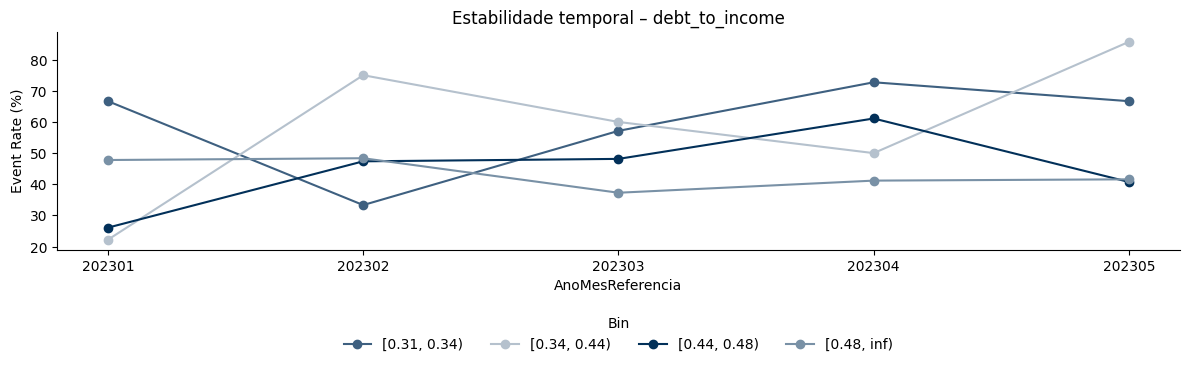

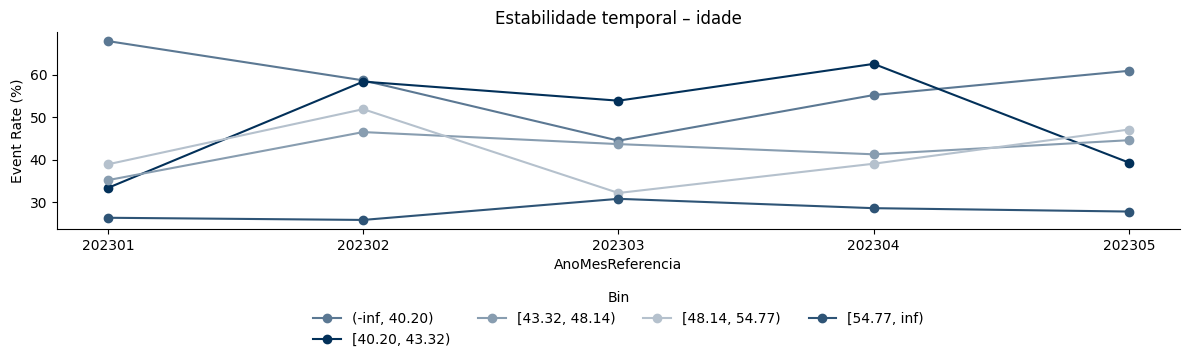

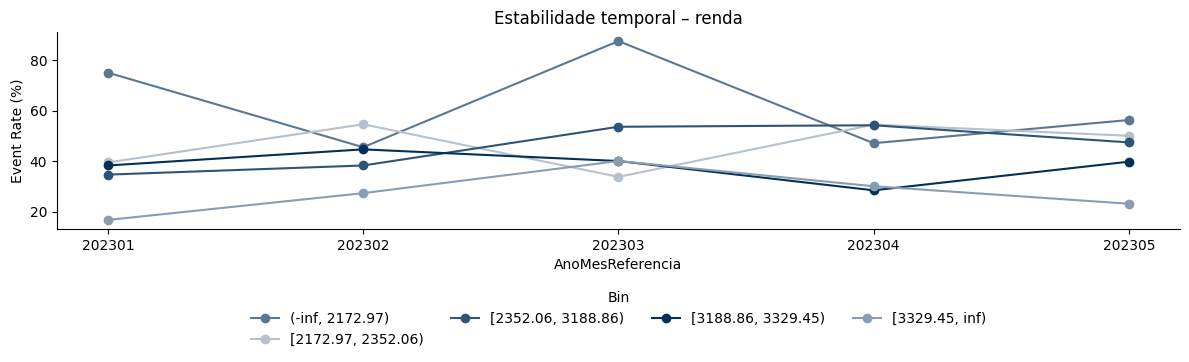

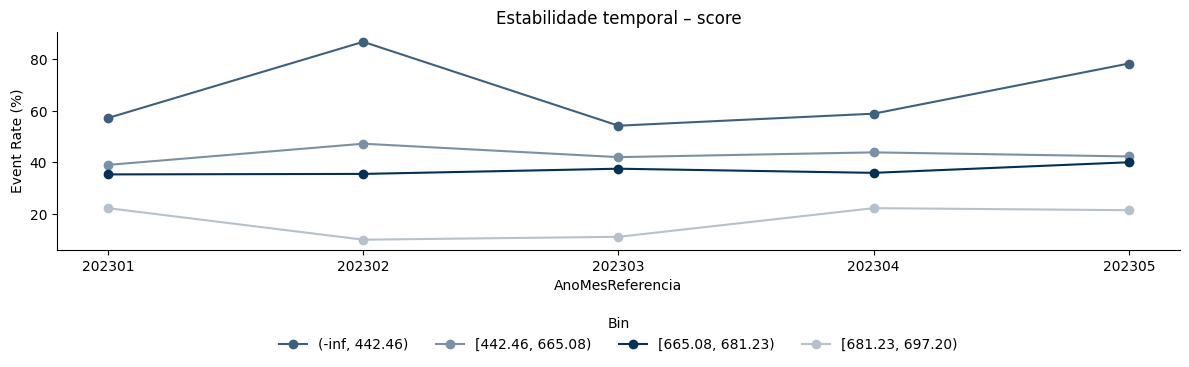

In [5]:
# calcular pivot (já inclui a coluna AnoMesReferencia em X)
pivot = binner.stability_over_time(
    X=df[["idade", "renda", "score", "debt_to_income", "AnoMesReferencia"]],
    y=df["default_90d"],
    time_col="AnoMesReferencia",
)

pivot.to_excel('pivot.xlsx')

# chama o wrapper da própria classe
binner.plot_event_rate_stability(
    pivot,
    time_col_label="AnoMesReferencia",
)


In [6]:
# # testar NASABinner COM Optuna
binner_opt = NASABinner(
    strategy="supervised",
    use_optuna=True,
    check_stability=True,
    monotonic="descending",
    strategy_kwargs={"n_trials": 15}
)

binner_opt.fit(X, y, time_col="AnoMesReferencia")
print("IV:", round(binner_opt.iv_, 4))
print("Melhores parâmetros:", binner_opt.best_params_)


[I 2025-06-03 01:55:55,357] A new study created in memory with name: no-name-6f1127f5-27f8-4a73-a542-686d8799aa2c
[I 2025-06-03 01:55:55,757] Trial 0 finished with value: 0.14988025244590503 and parameters: {'max_bins': 7, 'min_bin_size': 0.0689121978819932, 'min_event_rate_diff': 0.07847231515746764}. Best is trial 0 with value: 0.14988025244590503.
[I 2025-06-03 01:55:56,184] Trial 1 finished with value: 0.13576204401360137 and parameters: {'max_bins': 5, 'min_bin_size': 0.06697660942116276, 'min_event_rate_diff': 0.09984635783704714}. Best is trial 1 with value: 0.13576204401360137.
[I 2025-06-03 01:55:56,569] Trial 2 finished with value: 0.14146906417118804 and parameters: {'max_bins': 4, 'min_bin_size': 0.04027454491746473, 'min_event_rate_diff': 0.08030300539134783}. Best is trial 1 with value: 0.13576204401360137.
[I 2025-06-03 01:55:56,949] Trial 3 finished with value: 0.2065738845714664 and parameters: {'max_bins': 7, 'min_bin_size': 0.02859772845835855, 'min_event_rate_diff':

IV: 0.0059
Melhores parâmetros: {'max_bins': 6, 'min_bin_size': 0.06256934507505285, 'min_event_rate_diff': 0.09185993819536373}


In [9]:
# plotar estabilidade do modelo com Optuna

# calcular pivot (já inclui a coluna AnoMesReferencia em X)
pivot_opt = binner_opt.stability_over_time(
    X=df[["idade", "renda", "score", "debt_to_income", "AnoMesReferencia"]],
    y=df["default_90d"],
    time_col="AnoMesReferencia",
)

pivot_opt.to_excel('pivot.xlsx')

# chama o wrapper da própria classe
binner_opt.plot_event_rate_stability(
    pivot_opt,
    time_col_label="AnoMesReferencia",
    title_prefix="Estabilidade temporal - com Optuna"
)

KeyError: 3